## Extract Data

## Libraries

In [1]:
import ee
import geopandas as gpd
import rasterio
import os
from rasterio.mask import mask
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
ee.Authenticate()
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


## Random Sampling Over the Selected Area

In [12]:
# Initialize Earth Engine

# Define the region of interest (ROI)
#roi = huambo.geometry()
#roi = huambo.geometry()
#roi = 15.133014,-9.90806,15.851245,-9.687479
#roi = ee.Geometry.Rectangle([15.133014,-9.90806,15.851245,-9.687479])  # kwanza sul
#roi = ee.Geometry.Rectangle([13.555392,-9.029986,14.104708,-8.851593]) #Bengo
#roi = ee.Geometry.Rectangle([13.1515,-9.24948,13.56692,-8.794442]) #Luanda city
#roi = ee.Geometry.Rectangle([14.998835,-13.639018,16.352299,-12.138639]) ## Huambo agric
#roi = ee.Geometry.Rectangle([12.874434,-13.967335,15.060713,-11.890144]) ## Benguela agric
#roi = ee.Geometry.Rectangle([15.61878,-13.557116,16.085699,-13.072012]) ## huambo river
#roi = ee.Geometry.Rectangle([13.363726,-8.771447,13.503802,-8.688648]) ## river caxito


# Load Sentinel-2 Image Collection and compute median image
sentinel_collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(roi) \
    .filterDate('2019-01-01', '2019-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
sentinel_median = sentinel_collection.select(selected_bands).median().clip(roi)

# Compute NDVI and NDWI
ndvi = sentinel_median.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = sentinel_median.normalizedDifference(['B3', 'B8']).rename('NDWI')

# Combine all bands and indices into a single image
combined_image = sentinel_median.addBands([ndvi, ndwi])

# Load the Landcover classification image
landcover_image = ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019") \
    .select('discrete_classification') \
    .clip(roi)

# Combine land cover labels with the spectral bands and indices
labeled_image = combined_image.addBands(landcover_image.rename('Label'))

# Sample the data and include geometries
num_samples =5000  # Adjust based on the computational resources.
sample = labeled_image.sample(
    region=roi,
    scale=50,
    numPixels=num_samples,
    seed=42,
    geometries=True  # Include geometry to get coordinates
)

# Convert the sampled data to a Python dictionary
sample_data = sample.getInfo()


## Feature Extraction/Rename

In [13]:
# Extract features, labels, and coordinates from the sampled data
data = []
for feature in sample_data['features']:
    properties = feature['properties']
    # Get the coordinates (longitude, latitude)
    coords = feature['geometry']['coordinates']
    properties['longitude'] = coords[0]
    properties['latitude'] = coords[1]
    data.append(properties)

# Create the DataFrame
df = pd.DataFrame(data)

# Rename columns for clarity
df.rename(columns={
    'B2': 'B2_Blue',
    'B3': 'B3_Green',
    'B4': 'B4_Red',
    'B8': 'B8_NIR',
    'B11': 'B11_SWIR1',
    'B12': 'B12_SWIR2',
    'Label': 'Label'
}, inplace=True)

# Display the first few rows
print(df.head())

   B11_SWIR1  B12_SWIR2  B2_Blue  B3_Green  B4_Red  B8_NIR  Label      NDVI  \
0        408        235     1440      1424    1144     670    200 -0.261301   
1        279        198     1389      1323    1037     619    200 -0.252415   
2       2224       1455     1393      1258    1251    2063     50  0.245021   
3       2781       2287     1521      1518    1698    2176     50  0.123387   
4       2694       2084     1543      1455    1607    2262     50  0.169294   

       NDWI  longitude  latitude  
0  0.360076  13.364910 -8.771375  
1  0.362513  13.369402 -8.771375  
2 -0.242397  13.385571 -8.771375  
3 -0.178127  13.386919 -8.771375  
4 -0.217111  13.390063 -8.771375  


## Save sample as csv

In [15]:
df.to_csv("sample1.csv")

## Plot the sample

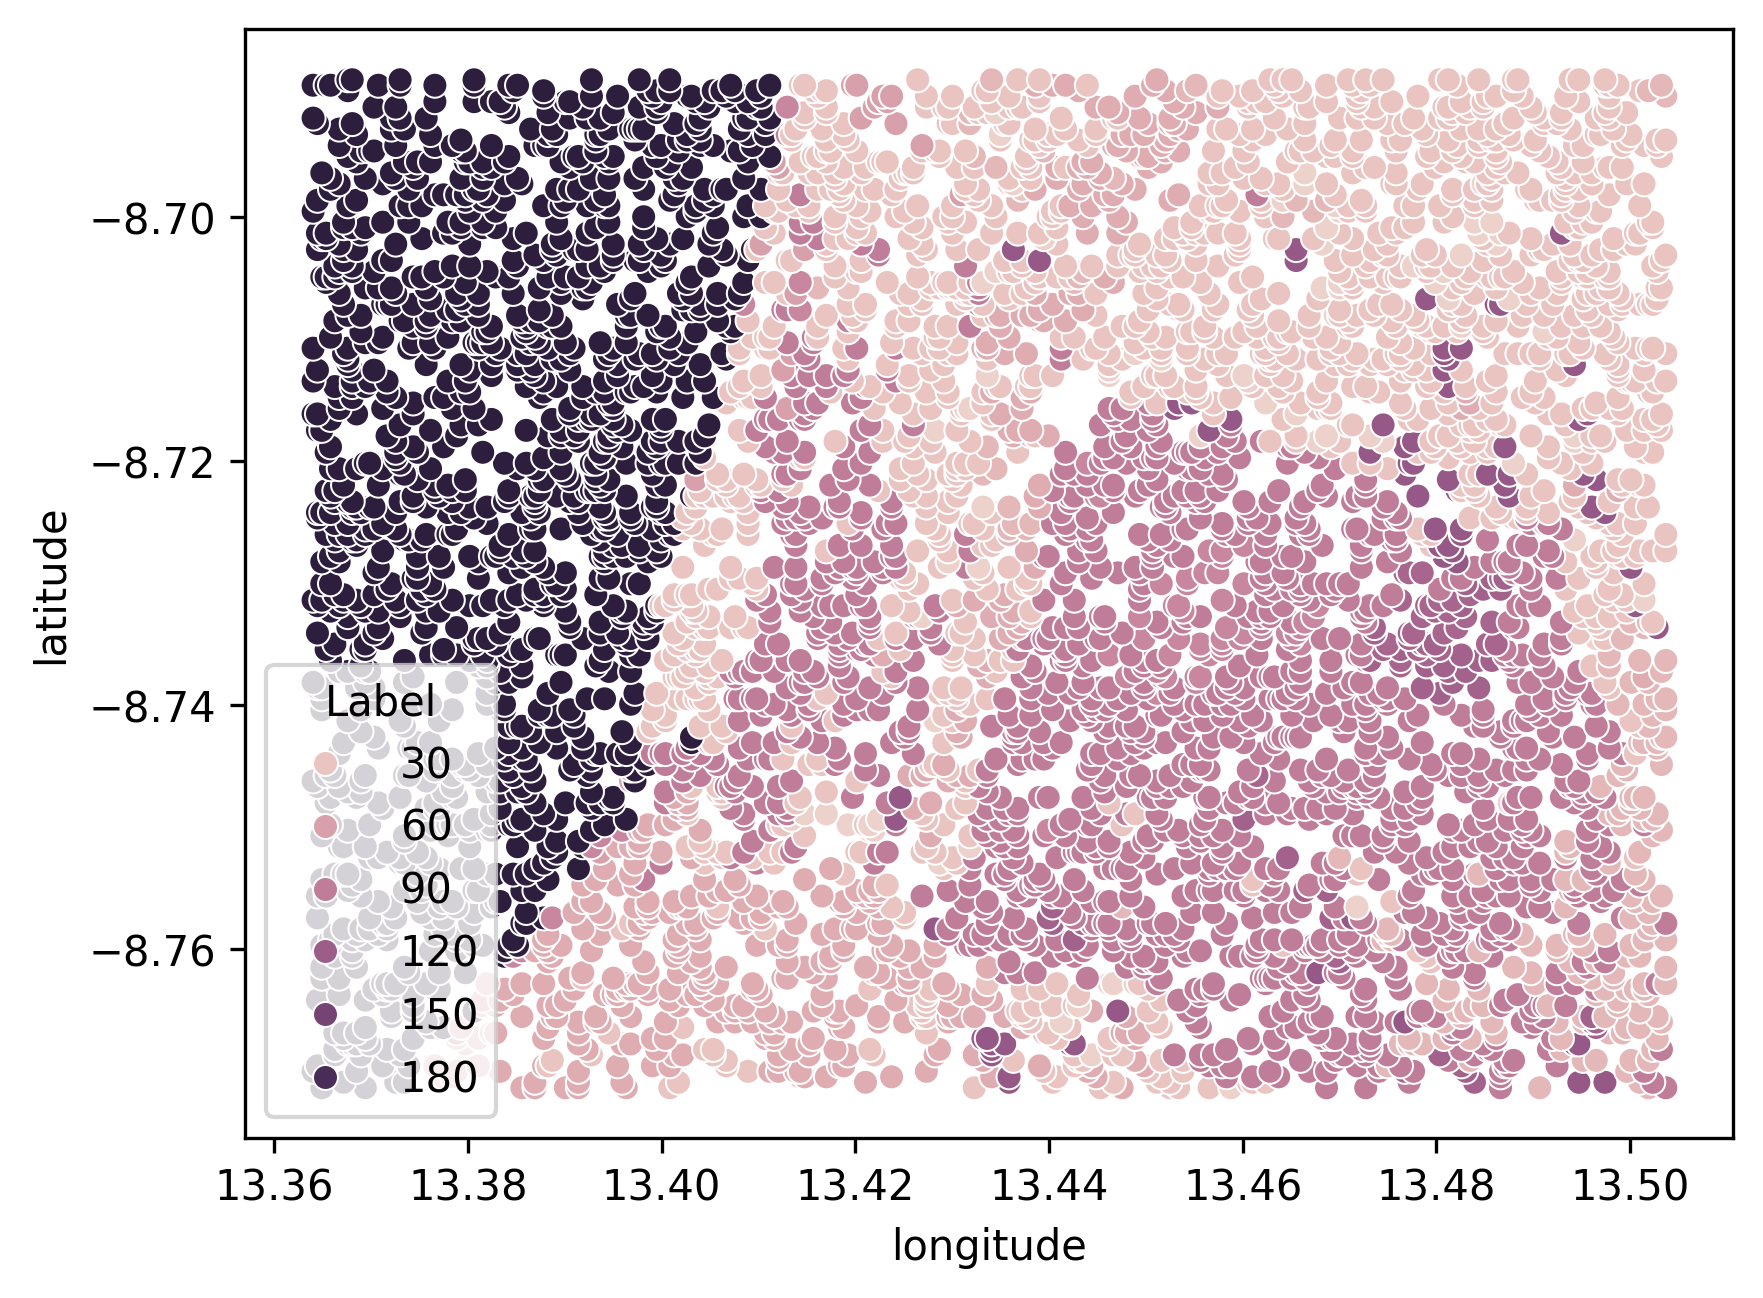

In [18]:
plt.rcParams["figure.dpi"] = 300

sns.scatterplot(
   x="longitude",
   y="latitude",
   data=df,
   hue='Label',
)

plt.show()

## Class Descriptions

In [19]:
n_grass = {20:1,30:2,40:3,50:4,80:7,90:8,114:13,116:15,124:19,126:21}

land_set = {
    1:"""Shrubs. Woody perennial plants with persistent and woody stems and without any defined main stem being less than 5 m tall. 
    The shrub foliage can be either evergreen or deciduous.""",
    2:"""Herbaceous vegetation. Plants without persistent stem or shoots above ground and lacking definite firm structure. Tree and shrub cover is less
    than 10 %.""",
    3:"""Cultivated and managed vegetation / agriculture. Lands covered with temporary crops followed by harvest
    and a bare soil period (e.g., single and multiple cropping systems).
    Note that perennial woody crops will be classified as the appropriate
    forest or shrub land cover type.""",
    4:"""Urban / built up. Land covered by buildings and other man-made structures.""",
    7:"""Permanent water bodies. Lakes, reservoirs, and rivers. Can be either fresh or salt-water bodies.""",
    8:"""Herbaceous wetland. Lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt,
    brackish, or fresh water.""",
    13:"""Closed forest, deciduous broad leaf. Tree canopy >70 %, consists of seasonal broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.""",
    15:"""Closed forest, not matching any of the other definitions.""",   
    19:"""Open forest, deciduous broad leaf. Top layer- trees 15-70 % and second layer- mixed of shrubs and grassland, consists of seasonal broadleaf tree communities with
    an annual cycle of leaf-on and leaf-off periods.""",
    21:""" Open forest, not matching any of the other definitions."""

}